# Introduction
This notebook gives suggests how to solve the problem of non-linear compressible flow using the automatic differentiation library included in PorePy. 

Similar tutorials include:
- Solving same non-linear compressible flow using third party AD-software please see tutorial: "AutomaticDifferentiationWithThirdPartySoftware".
- Solving a linear slightly compressible flow problem see tutorial:  slightly_compressible_flow


# Model
As an example, we will set up a non-linear problem for compressible flow. As usuall, we assume Darcy's law is valid:
$$
\vec u = \mathcal K \nabla p,
$$
where $\vec u$ is the flux, $\mathcal K$ the permeability tensor and $p$ the fulid pressure. Further, the conservation of mass gives
$$
\frac{\partial \phi \rho}{\partial t} + \nabla \cdot \rho \vec u = q,\quad \text{in}\ \Omega \\
u\cdot n = 0,\quad \text{on}\ \partial \Omega
$$
for porosity $\phi$, fluid density $\rho$, and source/sink term $q$.

To solve this system of equation we need a constitutive law relating the fluid density to the pressure:
$$
\rho = \rho_r e^{c(p - p_r)},
$$
for reference density $\rho_r$ and pressure $p_r$.

## Import statements

In [1]:
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt

# Porepy modules
from porepy.grids import structured
from porepy.numerics.fv import tpfa
from porepy.params.data import Parameters
from porepy.viz.plot_grid import plot_grid
from porepy.ad.forward_mode import Ad_array
import porepy.ad.functions as af

## Define constitutive laws and constants

In [2]:
# Create grid
gb = structured.CartGrid([11,11])
gb.compute_geometry()

We set the porosity to 0.2 and let set the permeability to the default value (i.e. $\mathcal K = 1$).
We define the depenecy of $\rho$ on $p$ as a function

In [3]:
# Define data
dt = 0.2                           # Time step
phi = 0.2                          # Porosity 
c = 1e-1                           # Compressibility

# Set data
data = {'param': Parameters(gb)}
data['param'].set_porosity(phi)

# Constitutive law
def rho(p):
    rho0 = 1
    p_ref = 1
    return rho0 * af.exp(c * (p - p_ref))

## Discretization
We create discretized versions of the operators div. div is a mapping from faces to cells, and the divergence at a cell is the sum of the values on the faces (possibly multiplied with -1 if the normal vector of the face points into the cell).

The density is defined at the cell centers, but in the divergence term we need to evaluate it at the faces. To do so, we will simply take the average of the two neighbooring cells.

In [4]:
cell_faces_T = gb.cell_faces.T
def div(x):
    """
    Discrete divergence
    """
    return cell_faces_T * x

def avg(x):
    """
    Averageing. Note that this is not strictly correct for the boundary faces since
    these only have 1 cell neighboor, but we have zero flux condition on these, so 
    this is not a problem.
    """
    return 0.5 * np.abs(gb.cell_faces) * x

### Flux discretization
To discretize the flux operator $-\mathcal K \nabla$ we use the two point flux apporoximation. This is implemented as the class Tpfa in PorePy. When we call Tpfa.discretize(...) we will store the dizcretisation as a scipy matrix in the data dictionary with a keyword 'flux'

In [5]:
# Define flux discretization:
flx_disc = tpfa.Tpfa('flow')
# Discretize
flx_disc.discretize(gb, data)

## Residual function
We insert Darcy's law into the mass conservation, and write this on residual form. We use backward Euler to discretize in time. This gives us the residual
$$
\phi \frac{\rho^k - \rho^{k-1}}{\Delta t} - \text{div}(\text{avg}(\rho^k)\ u^k) - q^k = 0
$$

In [6]:
def f(p, p0):
    # darcy:
    u = data['flux'] * p

    # Source:
    src = np.zeros(gb.num_cells)
    src[60] = 1

    # Define residual function
    time = phi * (rho(p) - rho(p0)) / dt
    flux = div(avg(rho(p)) * u)
    lhs = time + flux
    rhs = src

    return lhs - rhs

## Initialize Ad variable
To initialize an AD variable create an Ad_array(...) with values equal the initial value and jacobian equal the identity matrix

In [7]:
# Set initial condition
p0 = np.ones(gb.num_cells)
p = Ad_array(p0, sps.diags(np.ones(p0.shape)))



## Time loop
We are now ready to set up the time loop. We will set up a simple Newton iteration to find the zero of the residual function.

Solving time step:  1


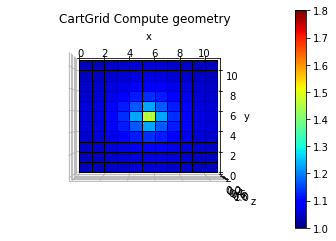

Solving time step:  2


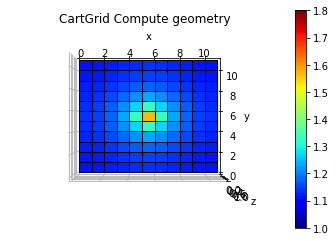

Solving time step:  3


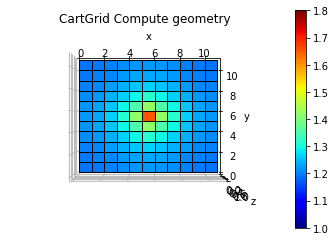

Solving time step:  4


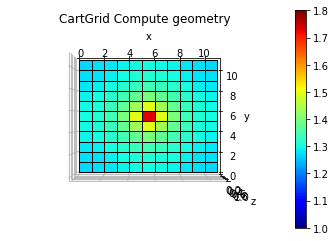

Solving time step:  5


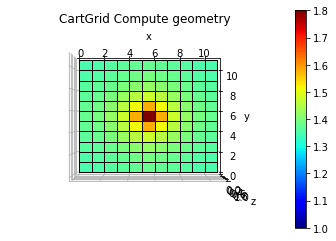

In [8]:
# define iteration parameters
newton_tol = 1e-6
t = .0
T = 1
k = 0
times = [t]

# Time loop
while t < T:
    # Increment time
    t += dt
    k += 1
    times.append(t)
    p0 = p.val
    print('Solving time step: ', k)
    # solve newton iteration
    err = np.inf
    while err > newton_tol:
        eq = f(p, p0)   
        p = p - sps.linalg.spsolve(eq.jac, eq.val)
        err = np.sqrt(np.sum(eq.val**2))
    plot_grid(gb, p.val,color_map = [1., 1.8])